I have absolutely no expertise in the field of EEG and MNE. This notebook is merely intended to share my understanding of this package through the HMS dataset. I have clearly referred to the official website https://mne.tools/dev/index.html and two videos from the YouTube channel EEG & MEG :: [Brain-Computer Interfaces] (https://www.youtube.com/@mlearnxyz), available at https://www.youtube.com/watch?v=IYuAPisoUeI&t=962sde and https://www.youtube.com/watch?v=wNIaT1UT6rI.

If experts come across this and wish to provide further insights, they are welcome!

# Introduction to MNE

MNE-Python stands as a robust Python library tailored for the intricate tasks of processing, analyzing, and visualizing neurophysiological data, with a specific focus on magnetoencephalography (MEG) and electroencephalography (EEG) data. Engineered with a comprehensive array of tools, this library empowers researchers and scientists to navigate the complexities of time-series neuroimaging data. By leveraging MNE-Python, professionals can conduct diverse analyses, unlocking profound insights into the intricate workings of brain activity.

Our exploration will delve into the practical application of this module using the HMS dataset, providing a hands-on experience to unravel its potential and functionalities in real-world scenarios.


# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import mne


data_train_path = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'

# Read the data (train.csv)

In [2]:
# Read the data
data = pd.read_csv(data_train_path)

# Copy the Data
df = data.copy()

# Observe few lines 
print(df.head())

       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

In [3]:
# Shape of the data
print('The shape of df is:', df.shape)

The shape of df is: (106800, 15)


# Creation of the main objects 

In order to understand the command of MNE, we will take the eeg_ids which has 5 expert consensus (the maximum) 'eeg_id'== 1460778765.

In [4]:
# Grouping the DataFrame by 'eeg_id' and counting the number of unique 'expert_consensus' values for each group
counts = df.groupby('eeg_id')['expert_consensus'].nunique()

# Select the eeg_id that have more than 4 unique expert consensus
eeg_id_with_multiple_consensus = counts[counts > 4].index.tolist()
print('Here is the list of eeg_id with more that 4 unique expert consensus' ,eeg_id_with_multiple_consensus)

# Take the eeg_id which as five expert consensus
df_multiple = df[df['eeg_id']==1460778765]
print(df_multiple)

Here is the list of eeg_id with more that 4 unique expert consensus [1460778765]
           eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
38052  1460778765           0                       0.0       747230293   
38053  1460778765           1                       6.0       747230293   
38054  1460778765           2                       8.0       747230293   
38055  1460778765           3                      10.0       747230293   
38056  1460778765           4                      12.0       747230293   
...           ...         ...                       ...             ...   
38281  1460778765         229                    2066.0       747230293   
38282  1460778765         230                    2068.0       747230293   
38283  1460778765         231                    2070.0       747230293   
38284  1460778765         232                    2084.0       747230293   
38285  1460778765         233                    2088.0       747230293   

       spectrogram

First we have to create essential MNE data structures (Raws, Events, Epochs, Evoked) with something called measurement information.

In [5]:
# Read the corresponding eeg
data_eeg_path = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1460778765.parquet'
data = pd.read_parquet(data_eeg_path).copy()

1. **Create measurement information**

This data structure behaves like a dictionary. It contains all metadata that is available for a recording. However, its keys are restricted to those provided by the FIF format specification, so new entries should not be manually added. (source MNE website)

In our case, since we do not have such file we create the info from scratch and we're going to use create_info. It contains the list of columns in the eeg, the type and the frequency which in our case is 200 samples per second.

Remark: the available types are ‘ecg’, ‘bio’, ‘stim’, ‘eog’, ‘misc’, ‘seeg’, ‘dbs’, ‘ecog’, ‘mag’, ‘eeg’, ‘ref_meg’, ‘grad’, ‘emg’, ‘hbr’ ‘eyetrack’ or ‘hbo’.

Since the EKG column does not correspond to cerebral activity but rather reflects heart activity, we will drop it from the dataset.

In [6]:
# Drop the EKG column
data = data.drop(['EKG'], axis=1)
print(data)

               Fp1          F3         C3         P3         F7         T3  \
0       -96.580002 -103.180000 -66.440002 -64.870003 -86.709999 -81.620003   
1       -82.940002  -92.989998 -60.110001 -59.560001 -78.160004 -74.459999   
2       -53.779999  -83.349998 -58.279999 -58.869999 -72.800003 -72.970001   
3       -75.110001  -84.830002 -53.970001 -55.430000 -71.669998 -63.680000   
4       -70.360001  -84.940002 -57.639999 -61.880001 -73.650002 -70.320000   
...            ...         ...        ...        ...        ...        ...   
427595   44.360001   35.540001  86.629997  73.150002  54.130001  64.720001   
427596    6.060000   -1.440000  52.490002  41.709999  29.590000  48.299999   
427597  -39.959999  -45.980000   7.160000  -1.930000  -9.510000   9.390000   
427598  -77.779999  -95.139999 -46.700001 -55.209999 -60.759998 -40.529999   
427599 -120.480003 -134.139999 -84.739998 -91.790001 -94.379997 -75.160004   

               T5         O1          Fz         Cz         Pz 

In [7]:
# Define the channel names
ch_names = data.columns.tolist()

# Define the channel types
ch_types = ['eeg']*len(ch_names) 

# Create the measurement information
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=200)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, F3, C3, P3, F7, T3, T5, O1, Fz, Cz, Pz, Fp2, F4, C4, P4, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 200.0 Hz
>


2. **Create the Raw object**

In MNE-Python, the Raw object is a fundamental data structure used to represent continuous neurophysiological data, such as EEG (electroencephalography) or MEG (magnetoencephalography) recordings. It is part of the MNE core data structures and is designed to store raw sensor data along with associated metadata.

- Raw Data: It holds the raw sensor data as a 2D NumPy array, where each row corresponds to a sensor (channel), and each column corresponds to a time point.

- Metadata: It's the measurement information which includes information about the recording, such as sensor locations, sampling frequency, channel names, and other relevant information.

- Methods for Data Analysis: The Raw object provides various methods for basic data analysis tasks, such as filtering, resampling, and applying annotations.

- Visualization: MNE-Python includes visualization tools to plot the raw data, allowing users to inspect and analyze the recordings.

To initialize a Raw object from the ground up, we begin by converting our DataFrame into a NumPy array and then transpose it.

In [8]:
# Create the numpy array and transpose it
data_values = data.values.T

# Create the Raw object
raw = mne.io.RawArray(data_values, info)
print(raw)

Creating RawArray with float64 data, n_channels=19, n_times=427600
    Range : 0 ... 427599 =      0.000 ...  2137.995 secs
Ready.
<RawArray | 19 x 427600 (2138.0 s), ~62.0 MB, data loaded>


Now we can plot the raw object. To do this, we define a scaling object and the duration. The rest of the commands is used for visualization convenience.

2138.0
Using matplotlib as 2D backend.


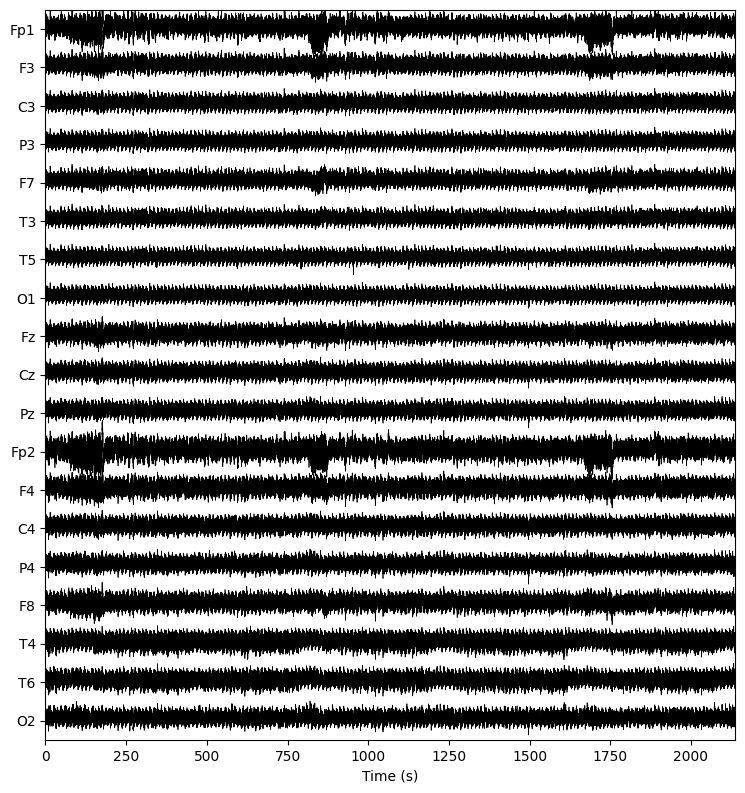

<Figure size 640x480 with 0 Axes>

In [9]:
# Define a scaling object
scalings = {'eeg': 300} 

# Define the duration of the eeg in second
duration = df_multiple['eeg_label_offset_seconds'].max()+50
print(duration)

# Plot the raw object
raw.plot(show_scrollbars=False, show_scalebars=False, duration= duration, scalings=scalings)
plt.tight_layout()

Before proceeding, we need to create a montage for the 19 electrodes.

In [10]:
# Create the montage
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(ten_twenty_montage)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


3. **Create the Epochs object**


Epochs objects provide a means of representing continuous data as a collection of time-locked trials, stored in an array of shape (n_events, n_channels, n_times). They are valuable for various statistical methods in neuroscience and facilitate a quick overview of what occurs during a trial.

To epoch the data, event markers are required, typically stored in the raw object within a channel known as the stimulus channel. In our scenario, we need to create these events, which is essentially an array in the format (time in samples, zero, trigger).

In [11]:
# Create Target
Target = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

# Create event ids for this eeg
event_ids = {'Seizure':0, 'LPD':1, 'LRDA':3, 'GRDA':4, 'Other':5}

# Create the events
events = df_multiple[['eeg_label_offset_seconds', 'expert_consensus']]
events.insert(1, 'New', 0)
print(events)

# Map 'expert_consensus' values to numerical labels using the 'event_ids' dictionary
events.loc[:,'expert_consensus'] = events['expert_consensus'].map(event_ids)

# Define the sample time point where the event occurs
events.loc[:,'eeg_label_offset_seconds'] = (events['eeg_label_offset_seconds']+25)*200

# Convert the data frame into an array
events = events.values.astype(int)
#print(events)


       eeg_label_offset_seconds  New expert_consensus
38052                       0.0    0              LPD
38053                       6.0    0              LPD
38054                       8.0    0              LPD
38055                      10.0    0              LPD
38056                      12.0    0              LPD
...                         ...  ...              ...
38281                    2066.0    0              LPD
38282                    2068.0    0              LPD
38283                    2070.0    0              LPD
38284                    2084.0    0          Seizure
38285                    2088.0    0          Seizure

[234 rows x 3 columns]


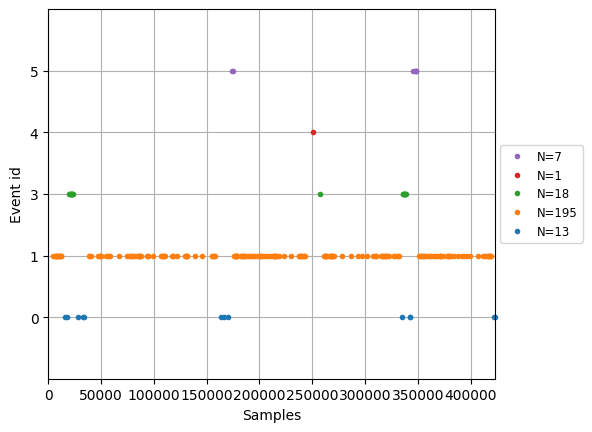

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot the events
mne.viz.plot_events(events[:])
plt.tight_layout()

Now, we generate epochs, representing time windows around events. Setting the starting time `tmin=-5` and ending time `tmax=5` creates a time window of 10 seconds around each event.

In [13]:
# Create the epochs
epochs = mne.Epochs(raw, events, event_id = event_ids, tmin=-5, tmax=5, preload=True, baseline=(None, 0))
print(epochs.event_id)

Not setting metadata
234 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 234 events and 2001 original time points ...
0 bad epochs dropped
{'Seizure': 0, 'LPD': 1, 'LRDA': 3, 'GRDA': 4, 'Other': 5}


You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


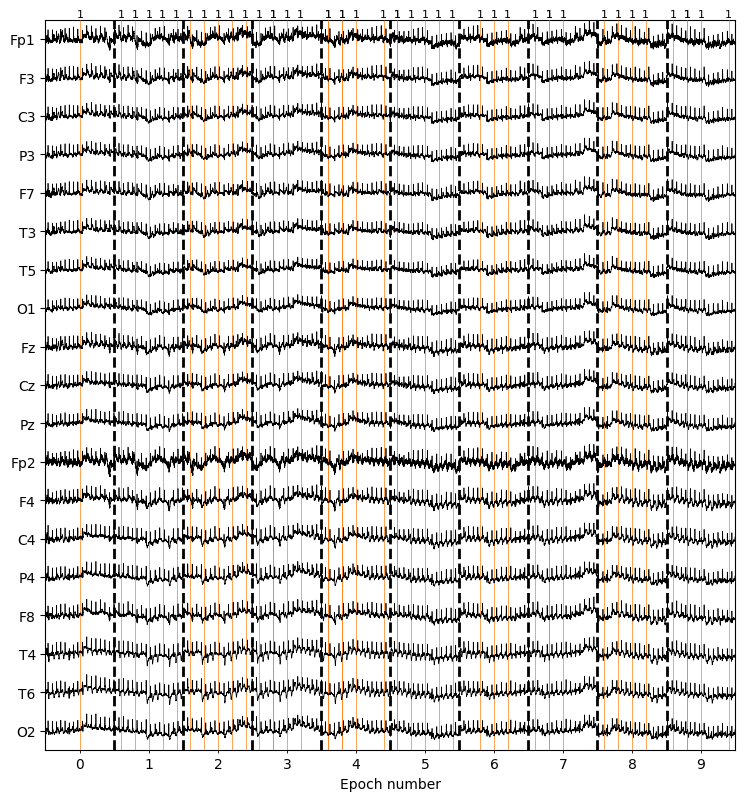

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot the 10th first epochs for all channels.
epochs.plot(n_epochs=10, events=True, picks = 'all', show_scrollbars=False, show_scalebars=False, scalings=scalings)
plt.tight_layout()

Many epochs overlap, likely due to closely spaced or identical events. To address the issue, we will select events that are spaced at least 10 seconds apart (non-overlapping events).

In [15]:
# Create the non overlapping events
events = df_multiple[['eeg_label_offset_seconds', 'expert_consensus']]
non_overlapping_events = pd.DataFrame(columns=events.columns)

# Create the list of all eeg_label_offset_seconds
list_eeg_label_offset_seconds = list(df_multiple['eeg_label_offset_seconds'])
print(list_eeg_label_offset_seconds)

[0.0, 6.0, 8.0, 10.0, 12.0, 16.0, 18.0, 20.0, 26.0, 28.0, 32.0, 34.0, 36.0, 38.0, 54.0, 66.0, 76.0, 78.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 118.0, 140.0, 144.0, 170.0, 174.0, 176.0, 210.0, 220.0, 222.0, 224.0, 226.0, 250.0, 260.0, 264.0, 266.0, 310.0, 346.0, 358.0, 368.0, 370.0, 372.0, 376.0, 384.0, 398.0, 402.0, 404.0, 406.0, 410.0, 412.0, 416.0, 442.0, 446.0, 448.0, 472.0, 510.0, 512.0, 518.0, 520.0, 524.0, 528.0, 562.0, 564.0, 566.0, 584.0, 622.0, 626.0, 628.0, 632.0, 634.0, 672.0, 702.0, 750.0, 752.0, 758.0, 760.0, 766.0, 792.0, 806.0, 824.0, 844.0, 852.0, 854.0, 858.0, 860.0, 862.0, 864.0, 866.0, 868.0, 870.0, 886.0, 890.0, 892.0, 896.0, 904.0, 906.0, 908.0, 922.0, 932.0, 940.0, 946.0, 952.0, 968.0, 978.0, 980.0, 984.0, 988.0, 996.0, 1010.0, 1022.0, 1032.0, 1040.0, 1044.0, 1046.0, 1048.0, 1050.0, 1054.0, 1056.0, 1070.0, 1092.0, 1126.0, 1160.0, 1164.0, 1170.0, 1172.0, 1174.0, 1176.0, 1186.0, 1188.0, 1192.0, 1228.0, 1262.0, 1282.0, 1284.0, 1286.0, 1288.0, 1290.0, 1292.0, 130

In [16]:
# Generate a list of eeg_label_offset_seconds with a minimum separation of 10 seconds
new_list = []
current_offset = 0
min_distance = 10

while current_offset <= max(list_eeg_label_offset_seconds):
    new_list.append(current_offset)
    next_offset = next((x for x in list_eeg_label_offset_seconds if x >= current_offset + min_distance), None)
    if next_offset is None:
        break
    current_offset = next_offset
    
print(new_list)

[0, 10.0, 20.0, 32.0, 54.0, 66.0, 76.0, 86.0, 118.0, 140.0, 170.0, 210.0, 220.0, 250.0, 260.0, 310.0, 346.0, 358.0, 368.0, 384.0, 398.0, 410.0, 442.0, 472.0, 510.0, 520.0, 562.0, 584.0, 622.0, 632.0, 672.0, 702.0, 750.0, 760.0, 792.0, 806.0, 824.0, 844.0, 854.0, 864.0, 886.0, 896.0, 906.0, 922.0, 932.0, 946.0, 968.0, 978.0, 988.0, 1010.0, 1022.0, 1032.0, 1044.0, 1054.0, 1070.0, 1092.0, 1126.0, 1160.0, 1170.0, 1186.0, 1228.0, 1262.0, 1282.0, 1292.0, 1302.0, 1314.0, 1328.0, 1368.0, 1410.0, 1440.0, 1460.0, 1484.0, 1514.0, 1524.0, 1552.0, 1562.0, 1572.0, 1586.0, 1612.0, 1624.0, 1634.0, 1648.0, 1658.0, 1668.0, 1686.0, 1700.0, 1712.0, 1732.0, 1744.0, 1756.0, 1766.0, 1778.0, 1788.0, 1802.0, 1816.0, 1828.0, 1844.0, 1862.0, 1872.0, 1884.0, 1898.0, 1916.0, 1932.0, 1942.0, 1958.0, 1974.0, 2010.0, 2034.0, 2044.0, 2056.0, 2066.0, 2084.0]


In [17]:
# Create the non overlapping events
events = df_multiple[['eeg_label_offset_seconds', 'expert_consensus']]
non_overlapping_events = pd.DataFrame(columns=events.columns)

# Create a mask using the new_list
mask = events['eeg_label_offset_seconds'].isin(new_list)

# Apply the mask to get non-overlapping events
non_overlapping_events = events[mask]

# print the non_overlapping_events
non_overlapping_events.insert(1, 'New', 0)
print(non_overlapping_events)

# Map 'expert_consensus' values to numerical labels using the 'event_ids' dictionary
non_overlapping_events.loc[:,'expert_consensus'] = non_overlapping_events['expert_consensus'].map(event_ids)

# Define the sample time point where the event occurs
non_overlapping_events.loc[:,'eeg_label_offset_seconds'] = (non_overlapping_events['eeg_label_offset_seconds']+25)*200

# Convert the data frame into an array
non_overlapping_events = non_overlapping_events.values.astype(int)
#print(non_overlapping_events)

       eeg_label_offset_seconds  New expert_consensus
38052                       0.0    0              LPD
38055                      10.0    0              LPD
38059                      20.0    0              LPD
38062                      32.0    0              LPD
38066                      54.0    0          Seizure
...                         ...  ...              ...
38275                    2034.0    0              LPD
38276                    2044.0    0              LPD
38278                    2056.0    0              LPD
38281                    2066.0    0              LPD
38284                    2084.0    0          Seizure

[112 rows x 3 columns]


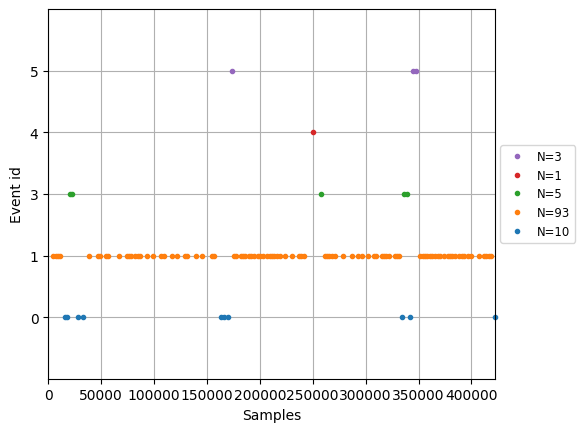

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot the events
mne.viz.plot_events(non_overlapping_events[:])
plt.tight_layout()

In [19]:
# Create the epochs
epochs = mne.Epochs(raw, non_overlapping_events, event_id=event_ids, tmin=-5, tmax=5, preload=True, baseline=(None, 0))
print(epochs.event_id)

Not setting metadata
112 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 112 events and 2001 original time points ...
0 bad epochs dropped
{'Seizure': 0, 'LPD': 1, 'LRDA': 3, 'GRDA': 4, 'Other': 5}


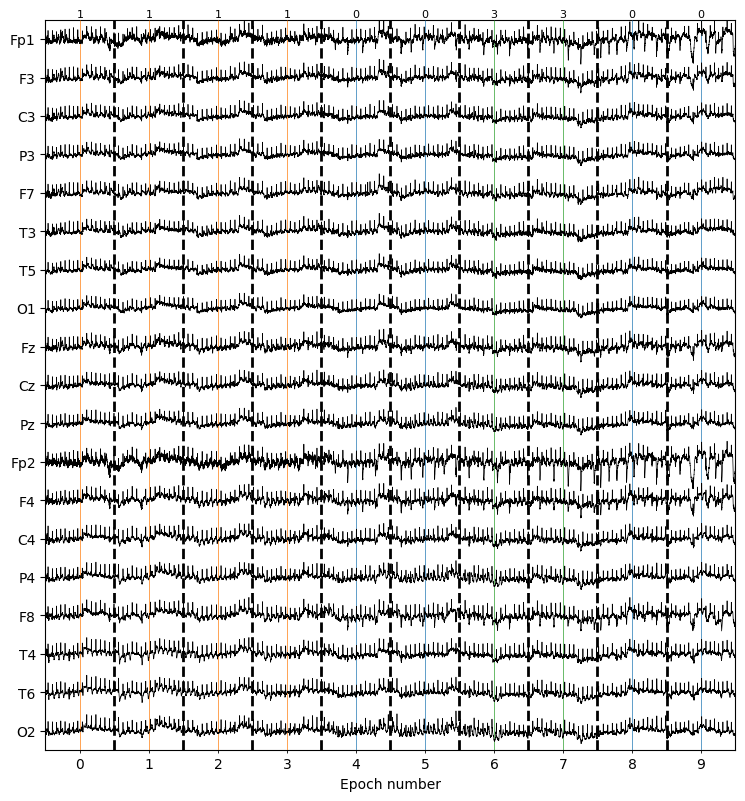

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot the 10th first epochs for all channels.
epochs.plot(n_epochs=10, events=True, picks = 'all', show_scrollbars=False, show_scalebars=False, scalings=300)
plt.tight_layout()

It's possible to select only one sample of epochs.

In [21]:
# Observe the information of the epochs associated to the event Seizure 
epochs['Seizure']

Number of events,10
Events,Seizure: 10
Time range,-5.000 – 5.000 s
Baseline,-5.000 – 0.000 s


We can get the information of the Epoch object.

In [22]:
# Observe the info
epochs.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


An intriguing aspect is that we can visualized the sensors.

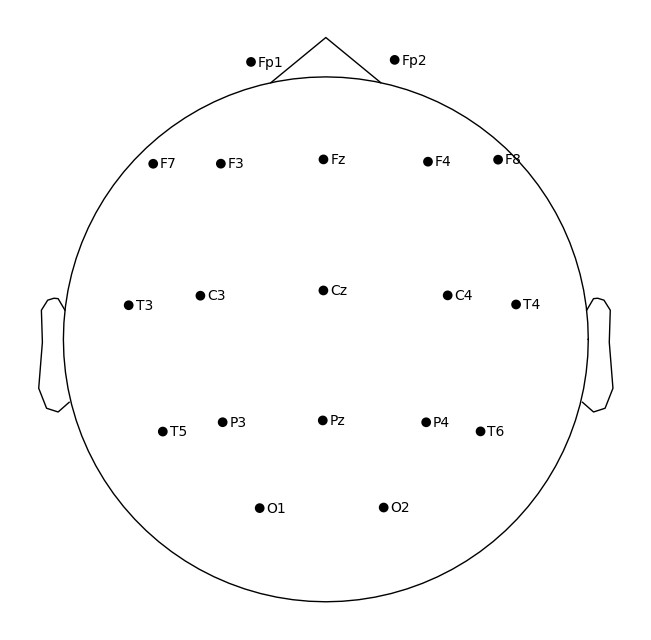

<Figure size 640x480 with 0 Axes>

In [23]:
# Display the sensors
epochs.plot_sensors(show_names=True)
plt.tight_layout()

# Study of the particular eeg

1. **Visualize epochs through heatmaps**

Let's visualize the activity within the epochs as a heatmap.  We will obtain a plot which represents the total number of epochs for a correponding brain activity event within a 10-second window for each channel; each pixel’s color representing the signal value at that time sample for that epoch.

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


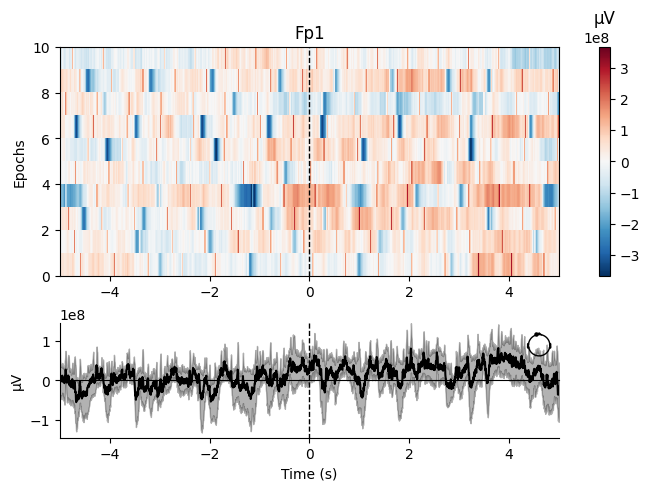

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


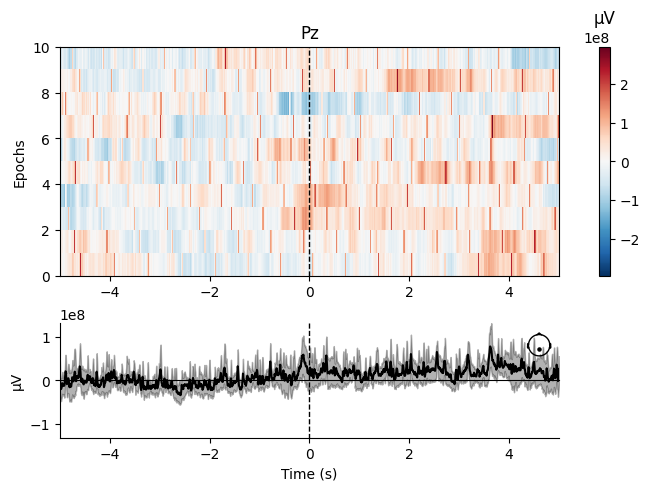

<Figure size 640x480 with 0 Axes>

In [24]:
#Plot the total number of epochs (10 epochs) corresponding to the Seizure event within the 10-second window for the first and the eleven-th channel
#(pick = [0] and pick = [10])
epochs['Seizure'].plot_image(picks=[0])
epochs['Seizure'].plot_image(picks=[10])
plt.tight_layout()

2. **Visualize average epochs for one particular brain activity**

Now, let’s take a look at some channels in the eeg averaged across epochs.

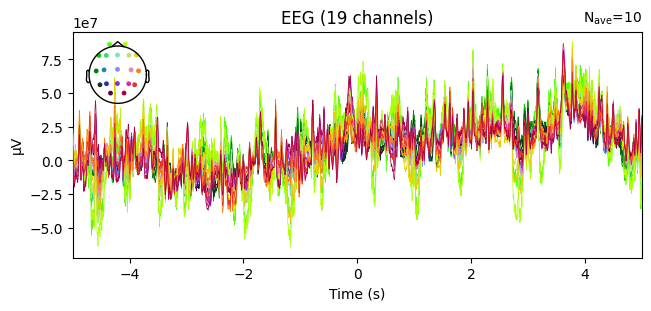

<Figure size 640x480 with 0 Axes>

In [25]:
# Define the average eeg
average_epochs_seizure = epochs['Seizure'].average()

# Get the measurement information
average_epochs_seizure.info

# Display the result for all channels
average_epochs_seizure.plot(picks='all')

plt.tight_layout()

Note for these figures: As they are now, I don't feel like they are particularly exploitable.


It's also possible to look at topographic map of the previous figure.

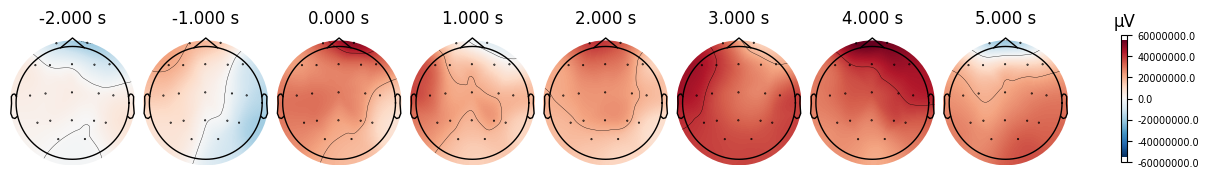

<Figure size 640x480 with 0 Axes>

In [26]:
# Display the topographic map
average_epochs_seizure.plot_topomap(times = [-2, -1, 0, 1, 2, 3, 4, 5])
plt.tight_layout()

We can also link it directly with the previous one

No projector specified for this dataset. Please consider the method self.add_proj.


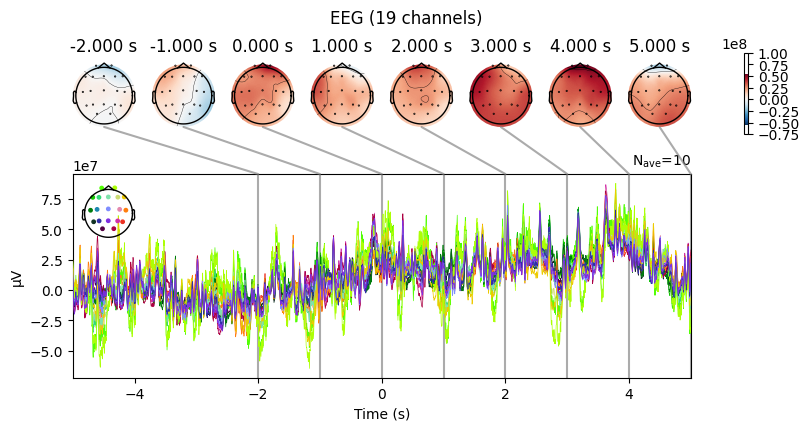

<Figure size 640x480 with 0 Axes>

In [27]:
# Display the topographic map
average_epochs_seizure.plot_joint(times = [-2, -1, 0, 1, 2, 3, 4, 5])
plt.tight_layout()

By combining the two plots, we can directly observe the evolution of the average of epochs across the sensors. It is evident that the maximum amplitude occurs between 3s and 4s.

3. **Visualize the power spectral density**

Now let’s check out the frequency content of our epochs and display all channel types by averaging across epochs.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/tmp/ipykernel_18/195142193.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


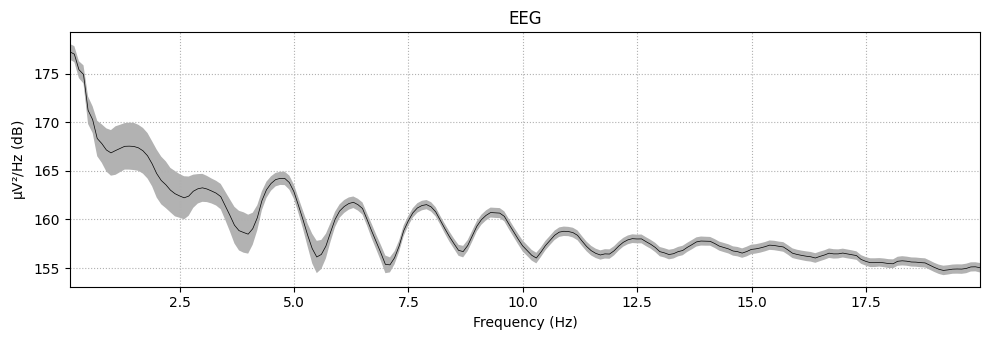

In [28]:
# Display the power spectral density (psd) 
epochs.compute_psd(fmin=0.01, fmax=20.0).plot(average=True, picks="all")
plt.tight_layout()

Now, let’s take a look at the spatial distributions of the PSD, averaged across epochs and frequency bands.

    Using multitaper spectrum estimation with 7 DPSS windows


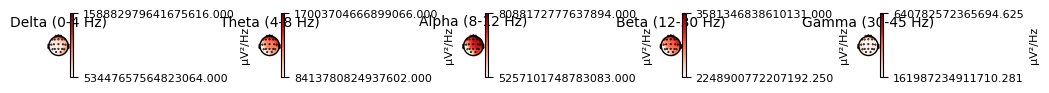

<Figure size 640x480 with 0 Axes>

In [29]:
# Display the spatial distributions of the PSD
epochs.compute_psd().plot_topomap(ch_type="eeg", normalize=False, contours=0)
plt.tight_layout()

Something more interesting is to compute epochs for each brain activity. Let's take Seizure as example.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/tmp/ipykernel_18/2666429362.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


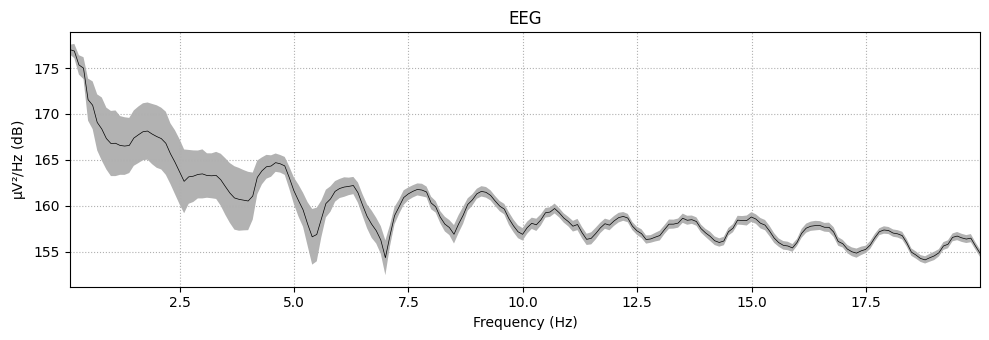

In [30]:
# Display the power spectral density (psd) for Seizure
epochs['Seizure'].compute_psd(fmin=0.01, fmax=20.0).plot(average=True, picks="all")
plt.tight_layout()

    Using multitaper spectrum estimation with 7 DPSS windows


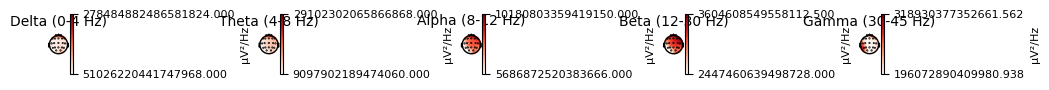

<Figure size 640x480 with 0 Axes>

In [31]:
# Display the spatial distributions of the PSD for Seizure
epochs['Seizure'].compute_psd().plot_topomap(ch_type="eeg", normalize=False, contours=0)
plt.tight_layout()

# Time-frequency analysis

Let's revisit the concept of time-frequency analysis: In signal processing, time–frequency analysis encompasses a set of techniques and methods employed to characterize and manipulate signals whose statistics vary over time, such as transient signals.

It represents a generalization and refinement of Fourier analysis, particularly applicable when the frequency characteristics of the signal change with time. Given that many signals of interest, such as speech, music, images, and medical signals, exhibit varying frequency characteristics, time–frequency analysis proves to be widely applicable across diverse fields.

There are several different ways to formulate a valid time–frequency distribution function, resulting in several well-known time–frequency distributions, such as: wavelet transform, STFT transform etc.

(https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis#:~:text=In%20signal%20processing%2C%20time%E2%80%93frequency%20analysis%20is%20a%20body%20of,time%2C%20such%20as%20transient%20signals.)


The goal is to explore the spectral content of the data, focusing on both frequency and time-frequency domains. Initially, we will address Epochs, but it's worth noting that time-frequency analysis can also be executed on a NumPy array.

1. **Frequency analysis**

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/tmp/ipykernel_18/3365388454.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_18/3365388454.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


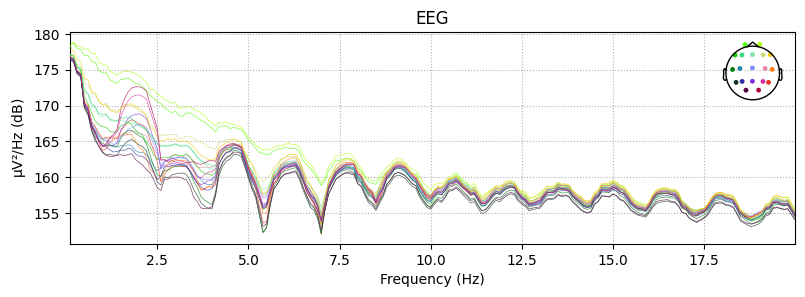

In [32]:
# Plot the epochs corresponding to Seizure in the range of frequencies 0.01Hz and 20Hz
epochs['Seizure'].plot_psd(fmin=0.01, fmax=20)
plt.tight_layout()

2. **Time-Frequency analysis**

We are now computing Time-Frequency Representations (TFRs) from our Epochs, specifically focusing on power and inter-trial coherence (ITC).

Various methods can be employed for TFRs, with the main ones being:

- Multitaper method: This method involves creating several orthogonal tapering windows in TFR estimation, effectively reducing variance. Parameters such as time_bandwidth can be adjusted, impacting multitaper properties and resulting in a different TFR. Trade-offs between time and frequency resolution can be made to achieve a variance reduction.

- Stockwell method: Utilizing a Gaussian window, this method balances temporal and spectral resolution. Notably, frequency bands are phase-normalized, ensuring strict comparability in terms of timing. The input signal can be recovered from the transform in a lossless manner, disregarding numerical errors. The width parameter is used to control spectral/temporal resolution by specifying different widths for the Gaussian window.

- Morlet wavelets: These are sinusoidal waves with a Gaussian envelope. The n_cycles parameter allows control over the balance between spectral and temporal resolution by defining the number of cycles to include in the window.

For more informations https://mne.tools/1.0/auto_examples/time_frequency/time_frequency_simulated.html.


The functions used for these computations are:

- mne.time_frequency.tfr_multitaper()
- mne.time_frequency.tfr_stockwell()
- mne.time_frequency.tfr_morlet()


In [33]:
# import the tfr
from mne.time_frequency import tfr_morlet, tfr_multitaper, tfr_stockwell

We will exclusively utilize Morlet wavelets, a method primarily employed for Time-Frequency Representations (TFRs). Let's explore the available parameters in the mne.time_frequency.tfr_morlet function:

- `inst`: The instance containing the data.
- `freqs`: The frequencies of interest.
- `n_cycles`: Number of cycles in the wavelet, either a fixed number or one per frequency. The number of cycles n_cycles and the frequencies of interest freqs define the temporal window length. This parameter controls the balance between spectral and temporal resolution.
- `use_fft`: If `True`, use FFT-based convolution.
- `return_itc`: If `True`, return inter-trial coherence (ITC).
- `decim`: The decimation factor.
- `n_jobs`: The number of jobs to run in parallel.
- `picks`: Channels to include. If `None`, include all channels.
- `zero_mean`: If `True`, subtract the mean of the time-domain data for each epoch.
- `average`: If `True`, average the power across frequencies.
- `output`: The type of output to return ('power' or 'complex').
- `verbose`: If not `None`, override default verbose level.

These options provide flexibility in customizing the Time-Frequency Representation (TFR) based on specific analysis requirements. For more explanations, check this link https://mne.tools/stable/generated/mne.time_frequency.tfr_morlet.html#mne.time_frequency.tfr_morlet.

In the context of time-frequency analysis, particularly when using Morlet wavelets, the choice of frequency values and the number of cycles is crucial.

In [34]:
# Define the range of frequencies
#freq = np.logspace(*np.log10([0.5, 20]), num=100)
freq = np.arange(0.5, 20, 0.01)

# Define the number of cycles
n_cycles = freq/2

#  Define the Morlet wavelet transform for the first epoch associated to the event seizure
power_seizure = tfr_morlet(epochs['Seizure'][0], freq, n_cycles = n_cycles, return_itc = False)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.5s


Let's break down the code snippet:

1. **`freq = np.logspace(*np.log10([0.5, 20]), num=100)`**: This line generates an array `freq` containing 100 logarithmically spaced frequency values between 0.5 and 20. Logarithmic spacing is often used in frequency analysis, especially when dealing with a wide range of frequencies. This ensures better resolution at lower frequencies while still covering a broad spectrum. Adjusting these parameters allows us to explore various spectrogram configurations.

2. **`n_cycles = freq/2`**: The number of cycles parameter for the Morlet wavelet is often related to the frequency of interest. In this case, it is setting `n_cycles` to be half of the frequency values in the `freq` array.

3. **`power_seizure = tfr_morlet(epochs['Seizure'][0], freq, n_cycles=n_cycles, return_itc=False)`**: Finally, the Morlet wavelet transform (`tfr_morlet`) is applied to the data corresponding to the 'Seizure' event. It uses the generated frequency values (`freq`) and the associated number of cycles (`n_cycles`). The `return_itc=False` argument indicates that only the power, not the inter-trial coherence, should be returned.

No baseline correction applied


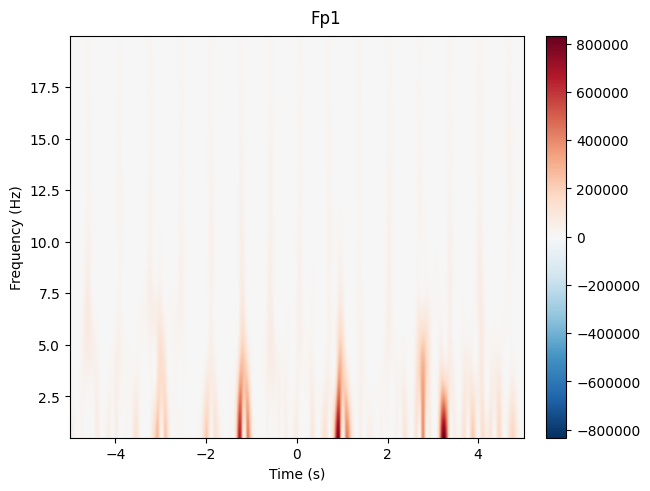

No baseline correction applied


<Figure size 640x480 with 0 Axes>

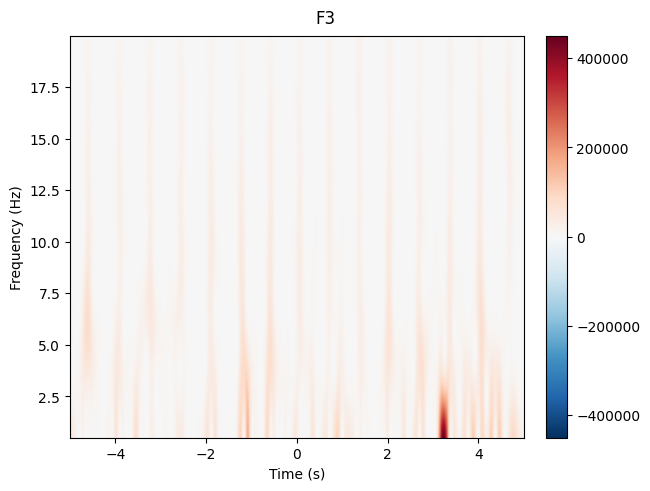

No baseline correction applied


<Figure size 640x480 with 0 Axes>

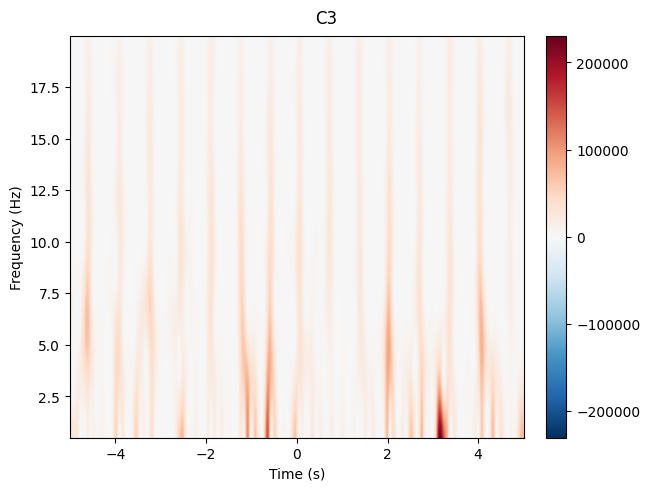

No baseline correction applied


<Figure size 640x480 with 0 Axes>

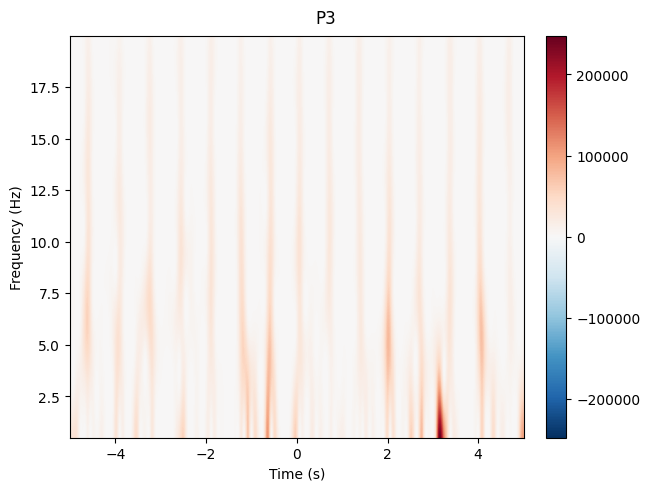

No baseline correction applied


<Figure size 640x480 with 0 Axes>

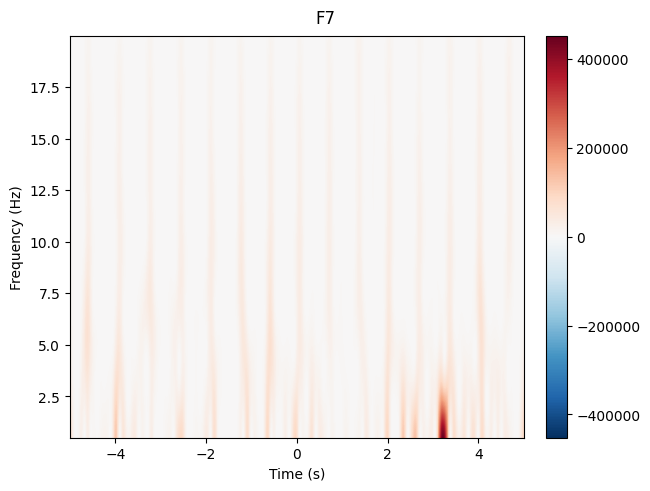

No baseline correction applied


<Figure size 640x480 with 0 Axes>

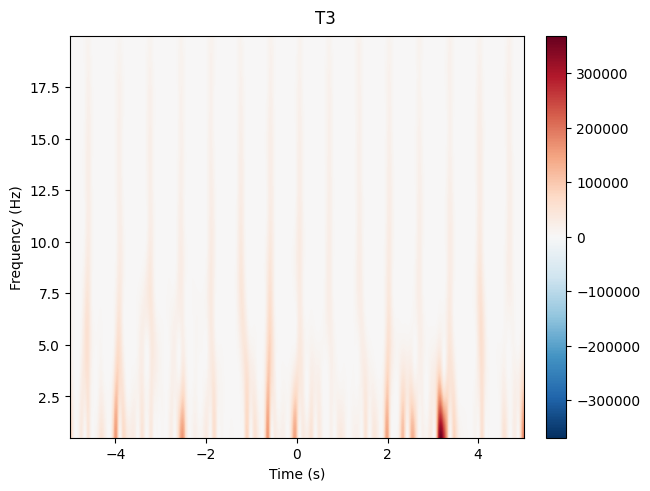

No baseline correction applied


<Figure size 640x480 with 0 Axes>

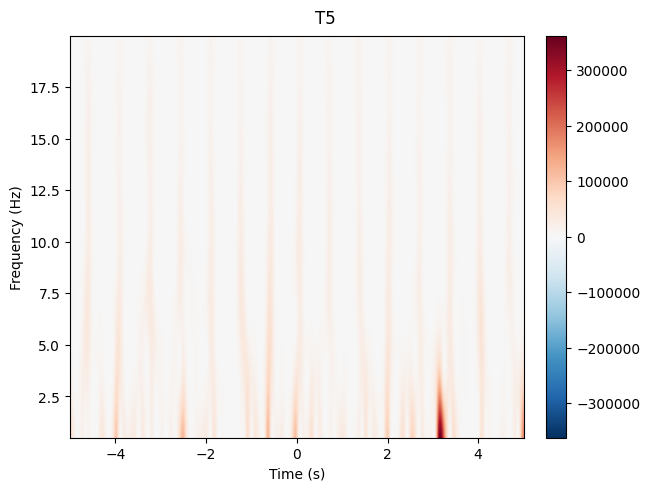

No baseline correction applied


<Figure size 640x480 with 0 Axes>

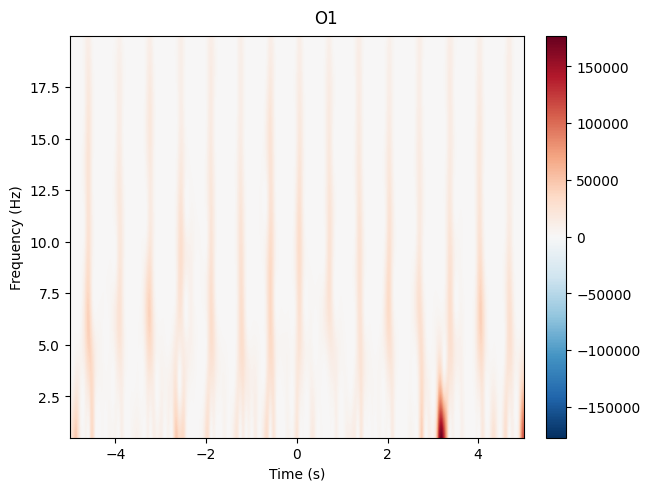

No baseline correction applied


<Figure size 640x480 with 0 Axes>

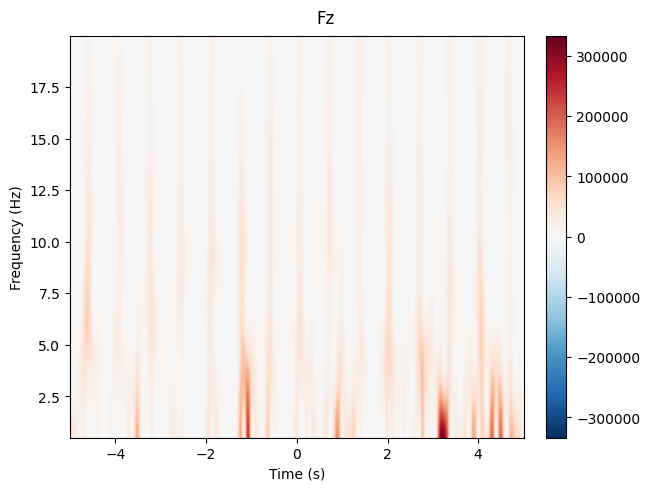

No baseline correction applied


<Figure size 640x480 with 0 Axes>

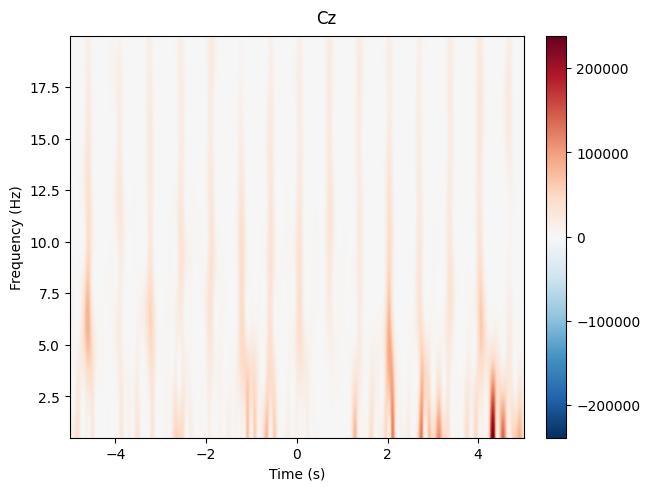

No baseline correction applied


<Figure size 640x480 with 0 Axes>

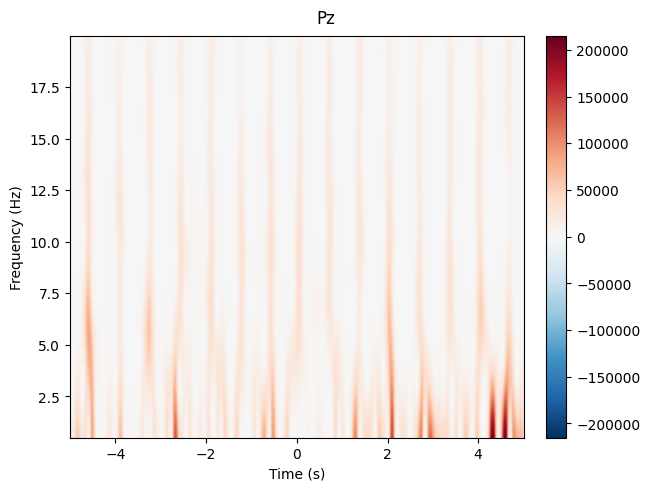

No baseline correction applied


<Figure size 640x480 with 0 Axes>

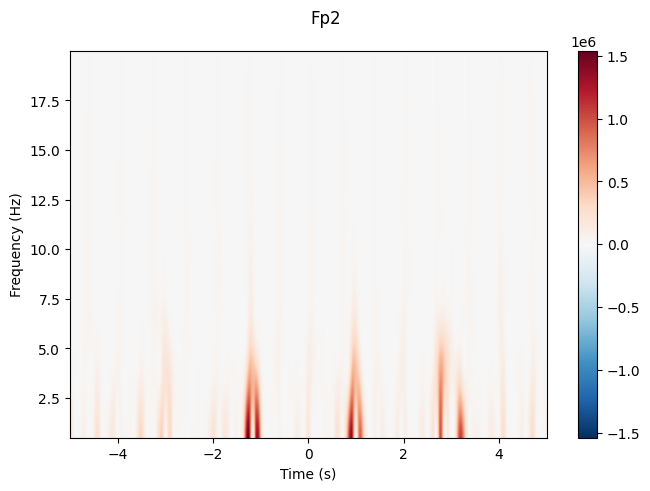

No baseline correction applied


<Figure size 640x480 with 0 Axes>

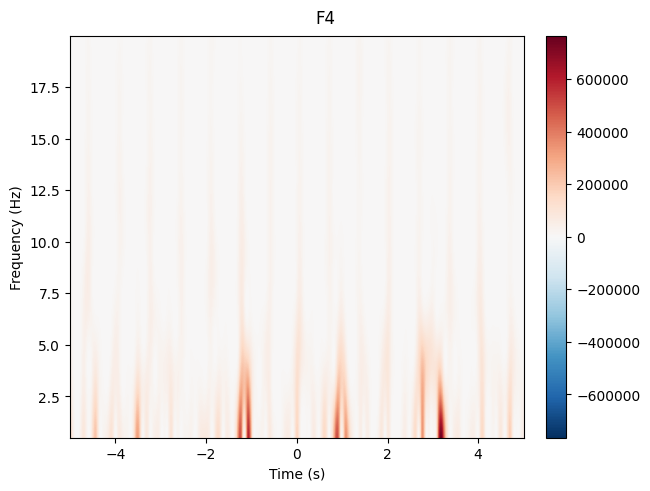

No baseline correction applied


<Figure size 640x480 with 0 Axes>

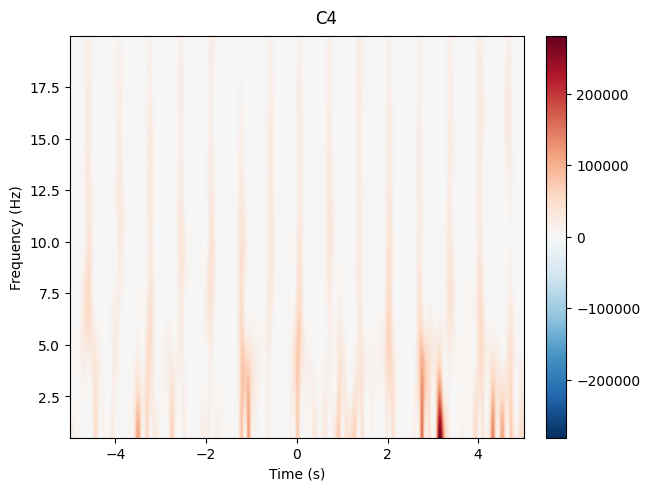

No baseline correction applied


<Figure size 640x480 with 0 Axes>

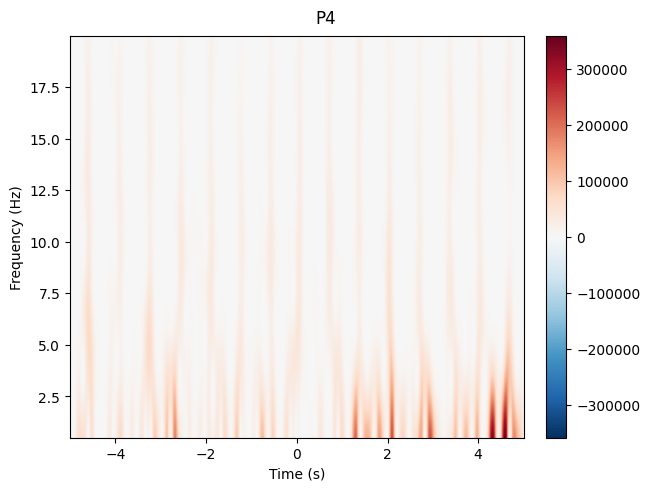

No baseline correction applied


<Figure size 640x480 with 0 Axes>

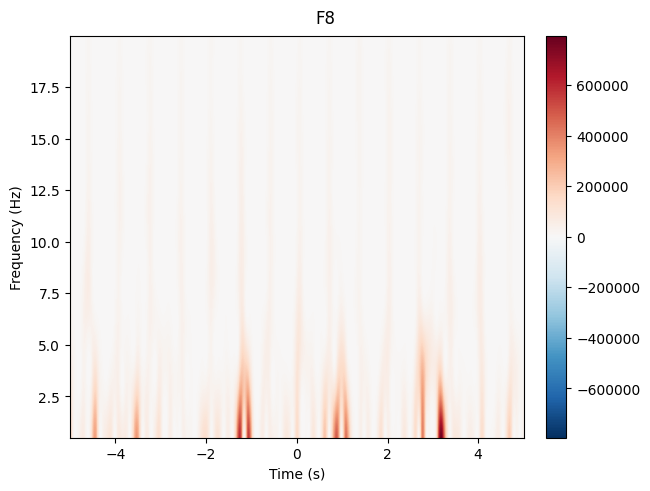

No baseline correction applied


<Figure size 640x480 with 0 Axes>

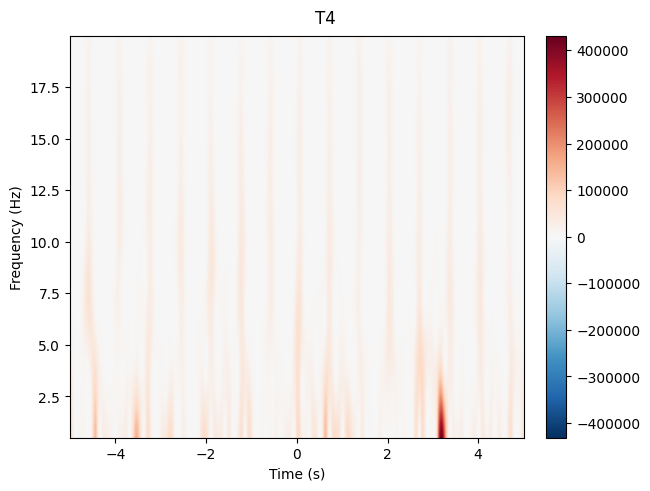

No baseline correction applied


<Figure size 640x480 with 0 Axes>

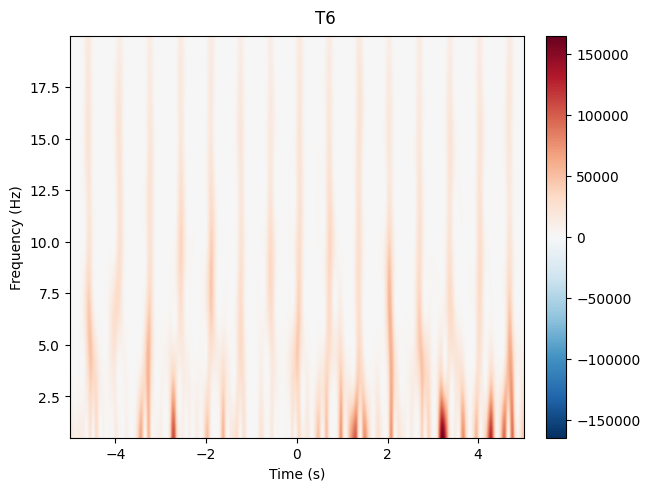

No baseline correction applied


<Figure size 640x480 with 0 Axes>

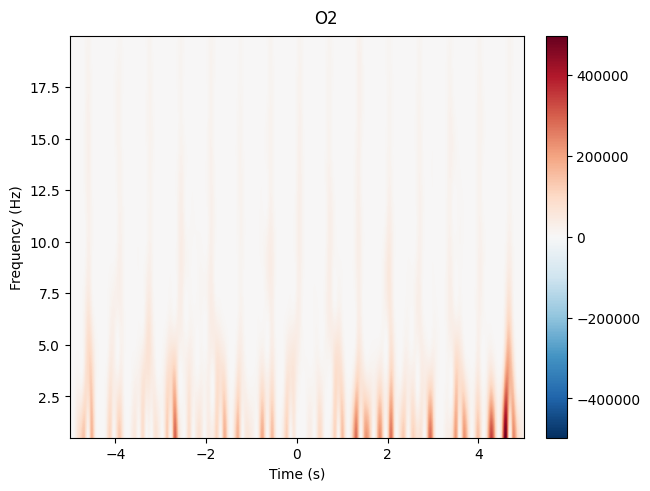

<Figure size 640x480 with 0 Axes>

In [35]:
# Plot the spectrogram for each channel
for title in ch_names:
    power_seizure.plot(picks=title, title=title)
    plt.tight_layout()

We can now generate Time-Frequency Representations (TFR) for individual epochs related to seizure events and for each channel. 

# Conclusion

In conclusion, MNE offers valuable methods for extracting and analyzing distinct features of brain activity, streamlining the exploration of EEG data. 


Leveraging the technique presented by @cdeotte in his notebook on converting EEG to spectrograms (https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg/notebook), I believe MNE provides the necessary tools to create various montage configurations and generate spectrograms with different TFR methods.

# To be continued! 